In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.spatial import HalfspaceIntersection, ConvexHull
from itertools import combinations
import networkx as nx

#### The Lemke-Howson algorithm, a deeper look
~
Here I had a lot of trouble understanding the algorithm, but found another great resource at https://cnl.gmu.edu/TAVRI/research/LemkeHowson.pdf, which was more intuitive, and what I follow for this section. A lot of the maths also comes from https://web.stanford.edu/~saberi/lecture4.pdf.

Here $U_1$ and $U_2$ are $(n,m)$ matricies representing the payoffs of both players. $s_1$ and $s_2$ are the strategies (probability vectors). $v_1$ and $v_2$ are constants representing the best each player can do, given the other player's strategy. Finally, $r_1$ and $r_2$ are vectors representing the gap between the reward for each action and the best action, given the other player's strategy. 

At equilibrium we have:

$$
\begin{align*}
\text{} \quad U_1\cdot s_2 + r_1 & = v_1 \\
\text{} \quad U_2^T\cdot s_1 + r_2 & = v_2 \\
\text{} \quad s_1\cdot r_1 & = 0 \\
\text{} \quad s_2\cdot r_2 & = 0 \\
\text{} \quad \sum s_1 & = 1\\
\text{} \quad \sum s_2 & = 1
\end{align*}
$$

The first two equations state what we had above, that the benefit of each action plus some number equals the benefit of the best action. The third and fourth lines state that an action either has 0 probability, or it is the best action (or tied-best). The fifth and sixth state that the strategies are probabilities. We also need the condition that all variables $\geq 0$, but I have left that out for now. 

We can simplify this further by dividing the first two lines by $v_1$ and $v_2$ respectively:

$$
\begin{align*}
\text{} \quad U_1\cdot s_2/v_1 + r_1/v_1 & = 1 \\
\text{} \quad U_2^T\cdot s_1/v_2 + r_2/v_2 & = 1 \\
\text{} \quad s_1\cdot r_1 & = 0 \\
\text{} \quad s_2\cdot r_2 & = 0 \\
\text{} \quad \sum s_1 & = 1\\
\text{} \quad \sum s_2 & = 1 \\
\end{align*}
$$

Defining $s_1^\prime=s_1/v_2$, $s_2^\prime=s_2/v_1$, $r_1^\prime=r_1/v_1$, and $r_2^\prime=r_2/v_2$ we can rewrite the equations above and get:

$$
\begin{align*}
\text{} \quad U_1\cdot s_2^\prime + r_1^\prime & = 1 \\
\text{} \quad U_2^T\cdot s_1^\prime + r_2^\prime & = 1 \\
\text{} \quad (v_2s_1^\prime)\cdot (v_1r_1^\prime) & = 0 \\
\text{} \quad (v_1s_2^\prime)\cdot (v_2r_2^\prime) & = 0 \\
\text{} \quad \sum s_1^\prime & = 1/v_2 \\
\text{} \quad \sum s_2^\prime & = 1/v_1 \\
\end{align*}
$$

In the third and fourth lines the constants don't matter, so we can remove them (we also do this for the condition that all variables are $\geq 0$):

$$
\begin{align*}
\text{} \quad U_1\cdot s_2^\prime + r_1^\prime & = 1 \\
\text{} \quad U_2^T\cdot s_1^\prime + r_2^\prime & = 1 \\
\text{} \quad s_1^\prime\cdot r_1^\prime & = 0 \\
\text{} \quad s_2^\prime\cdot r_2^\prime & = 0 \\
\text{} \quad \sum s_1^\prime & = 1/v_2 \\
\text{} \quad \sum s_2^\prime & = 1/v_1 \\
\end{align*}
$$

We can remove the last two equations as the utility (and equilibrium) don't depend on any scaling of the utility function. I.e., say $v_1=c_1v_1^\text{truth}$. As we are allowed any $c_1$ we can just use $c_1=1/(v_1^\text{truth}\sum s_2^\prime)$ to get $v_1=1/(\sum s_2^\prime)$. If we plug this back in the last two equations essentially become $1=1$ and can be removed. Essentially, we are just agreeing to normalise $s_1^\prime$ and $s_2^\prime$ when outputing the actual strategies. From now on we just drop the notation and assume it's fairly clear.

$$
\begin{align*}
\text{} \quad U_1\cdot s_2 + r_1 & = 1 \\
\text{} \quad U_2^T\cdot s_1 + r_2 & = 1 \\
\text{} \quad s_1\cdot r_1 & = 0 \\
\text{} \quad s_2\cdot r_2 & = 0 \\
\end{align*}
$$

The first equation above describes $n$ different equality relationships, in $n+m$ variables. The second equation above describes $m$ different equality relationships, also in a set of $n+m$ other variables. We know in order to solve the variables in the first equation we have to set $m$ of the variables to 0, and to solve the second we need to set $n$ of the variables to 0. Equivalently, we need to choose $n$ variables in the first to be non-zero, and $m$ in the second to be non-zero. All that remains after is to test the final 2 equations are true for the result. We could do this manually by looping through all posibilities, but we can notice something useful about the choice of variables...

At this point it's helpful to encode the first equation as $\big[I\text{ }U_1\big] \big(\begin{array}{c}r_1 \\s_2 \\\end{array}\big)=\mathbf{1}$, and likewise the second as $\big[U_2\text{ }I\big] \big(\begin{array}{c}s_1 \\r_2 \\\end{array}\big)=\mathbf{1}$. 

The reason for rewriting this way is that it makes it clear that in order to satisfy the last 2 equations we need to choose different columns to be non-zero in the first and second.

Take this example:

$
\begin{array}{c|cc}
\text{} & \text{X} & \text{Y} \\
\hline
\text{X} & 3,1 & 1,0 \\
\text{Y} & 0,0 & 2,2 \\
\end{array}
$

Using the above notation we get:

$
\big[I\text{ }U_1\big]=
\begin{array}{cccc}
r_1^1 & r_1^2 & s_2^1 & s_2^2 \\
\hline
1 & 0 & 3 & 1 \\
0 & 1 & 0 & 2 \\
\end{array}
$

$
\big[U_2\text{ }I\big]=
\begin{array}{cccc}
s_1^1 & s_1^2 & r_2^1 & r_2^2 \\
\hline
1 & 0 & 1 & 0 \\
0 & 2 & 0 & 1 \\
\end{array}
$

It's easy to see that each variable is the 'dual' of the one at the same position in the other table.

In order for $s_1\cdot r_1 = 0$ and $s_2\cdot r_2 = 0$ we need to choose non-zero columns which don't overlap. 

For example, the solution $s_1=[\frac{2}{3},\frac{1}{3}]$,$s_2=[\frac{1}{4},\frac{3}{4}]$ corresponds to the following choice (non-zero values in red, power is the action taken):

$
\big[I\text{ }U_1\big]=
\begin{array}{cccc}
r_1^1 & r_1^2 & \textcolor{red}{s_2^1} & \textcolor{red}{s_2^2} \\
\hline
1 & 0 & 3 & 1 \\
0 & 1 & 0 & 2 \\
\end{array}
\quad
\big[U_2\text{ }I\big]=
\begin{array}{cccc}
\textcolor{red}{s_1^1} & \textcolor{red}{s_1^2} & r_2^1 & r_2^2 \\
\hline
1 & 0 & 1 & 0 \\
0 & 2 & 0 & 1 \\
\end{array}
$

We can then find all Nash equilibria by simply trying every combination of $n$ non-zero variables in the first (deriving the $m$ non-zero in the second). We just need to solve the equations for those non-zero variables, and make sure the result is valid and greater than 0. 

In [2]:
U1_I = np.array([
    [1,0,3,1],
    [0,1,0,2]
])
U2T_I = np.array([
    [1,0,1,0],
    [0,2,0,1]
])
for comb1 in list(combinations(range(4), 2)):
    comb2 = tuple(set([0,1,2,3])-set(comb1)) # notice that we just get the opposite columns here
    if not np.linalg.det(U1_I[:,comb1])==0 and not np.linalg.det(U2T_I[:,comb2])==0: # check there is a solution
        solu1 = np.zeros(4)
        solu2 = np.zeros(4)
        solu1[np.array(comb1)] = np.linalg.inv(U1_I[:,comb1]).dot(np.ones(2)) # solve for the non-zero values
        solu2[np.array(comb2)] = np.linalg.inv(U2T_I[:,comb2]).dot(np.ones(2)) # solve for the non-zero values
        if all(solu1>=0) and all(solu2>=0): # check all variables >=0
            r1 = solu1[:2]
            s2 = solu1[2:]
            s1 = solu2[:2]
            r2 = solu2[2:]
            if np.sum(s1>0) and np.sum(s2>0): # need to just check the solution (0,0) wasn't found.
                if s1.dot(r1)==0 and s2.dot(r2)==0: # check the last two equations
                    s1 = np.round(s1/np.sum(s1),2)
                    s2 = np.round(s2/np.sum(s2),2)
                    print(f"solution: s1 {s1}, s2 {s2}")

solution: s1 [0. 1.], s2 [0. 1.]
solution: s1 [1. 0.], s2 [1. 0.]
solution: s1 [0.67 0.33], s2 [0.25 0.75]


This works and will find all Nash equilibria! But it is expensive - we have to do the inversion for every combination. As a final step we can speed this up a lot by turning it into a path-finding algorithm using the idea of pivoting.

#### Review of pivoting

I discussed pivoting in the '2 Distributed Optimization/D - Review of linear programs' notebook, but will repeat a lot of it again here. 

When we 'pivot' we increase a variable that was 0 until one of the other variables goes to 0. This means swapping one column for another, but without breaking the condition that all variables are at least 0. This way we know the solution is still valid. Unlike before, we don't provide the column to remove, this is found by calculation of a 'minimum ratio'.

When we just do pivoting we avoid storing the inverse of the matrix $A$ at the non-zero variables $B$, and instead update iteratively $A_B^{-1}A$ and $A_B^{-1}b$ in what is called a tableau, where $A_B^{-1}b$ is on the right and $A_B^{-1}A$ is the body of the matrix. 

For instance, the problem above where the two non-zero (basic) variables are $r_1^1$ and $r_1^2$ gives the following tableau:

$
\begin{array}{ccccc|c}
\text{} & r_1^1 & r_1^2 & s_2^1 & s_2^2 & = \\
\hline
r_1^1 & 1 & 0 & 3 & 1 & 1\\
r_1^2 & 0 & 1 & 0 & 2 & 1 \\
\end{array}
$

The values in the far right column are the setting to the values in the far left.

To add a variable $j$ (that is currently 0) we need to know what other value $i$ is to be removed. When you increase a variable by a unit of 1, all other variables which are currently positive need to decrease. We can work out their new values using the information in the tableau. Recall:

$$A_Bx_B + A_jx_j = b$$

Which can be turned into:

$$x_B = A_B^{-1}(b - A_jx_j)$$

If we want the other variable $i$ to be 0 it means:

$$x_{Bi} = A_{Bi}^{-1}(b_i - A_{ji}x_j)$$

Which becomes:

$$0 = A_{Bi}^{-1}b_i - A_{Bi}^{-1}A_{ji}x_j$$

And then:

$$x_j = A_{Bi}^{-1}b_i / A_{Bi}^{-1}A_{ji}$$

So to ensure all variables remain at least 0 we set the new value of $j$ using the minimum of this ratio over all $i$. In the table before, if we add $s_2^2$ we just need to divide the last column by the fourth to get the ratio:

$
\begin{array}{ccccc|c|c}
\text{} & r_1^1 & r_1^2 & s_2^1 & s_2^2 & = & \text{ratio} \\
\hline
r_1^1 & 1 & 0 & 3 & 1 & 1 & 1 \\
r_1^2 & 0 & 1 & 0 & 2 & 1 & \frac{1}{2} \\
\end{array}
$

This says we can increase $s_2^2$ up to $\frac{1}{2}$ and then $r_1^2$ will be 0. So in a pivot we can add the fourth column and then remove the second.

To pivot on the fourth and remove the second we just need to apply elementary row operations to make the fourth column 0 except in the second row, where it will be 1. It turns out this is equivalent to updating the inverse (see notebook mentioned before!). So we get:

$
\begin{array}{ccccc|c}
\text{} & r_1^1 & r_1^2 & s_2^1 & s_2^2 & = \\
\hline
r_1^1 & 1 & -\frac{1}{2} & 3 & 0 & \frac{1}{2} \\
s_2^2 & 0 & \frac{1}{2} & 0 & 1 & \frac{1}{2} \\
\end{array}
$

Note the row labels have changed. This now corresponds to the normalised strategy of $[0,1]$ for player 2. 

Say we pivot again and introduce the variable $s_2^1$. We can see the ratio will point to replacing $r_1^1$ and we get:

$
\begin{array}{ccccc|c}
\text{} & r_1^1 & r_1^2 & s_2^1 & s_2^2 & = \\
\hline
s_2^1 & \frac{1}{3} & -\frac{1}{6} & 1 & 0 & \frac{1}{6} \\
s_2^2 & 0 & \frac{1}{2} & 0 & 1 & \frac{1}{2} \\
\end{array}
$

Normalised this corresponds to the strategy of $[\frac{1}{4},\frac{3}{4}]$ for player 2.

**NOTE:** Pivoting seems to refer to both when you increase a variable from 0 until something else goes to 0, and the inverse case where you decrease a variable to 0, increasing something else. I guess the distinction is choosing which variable to leave vs choosing which to enter. Reading other versions of the following algorithm they describe choosing a variable to leave (based on the clash), rather than choosing one to 'fill in' the gap. I don't think there is a difference, but they might give different solutions.

In [3]:
def print_pivot_table(AB_inv_A, AB_inv_b, B):
    for i, basis_var in enumerate(B):
        row_data = ' '.join(f"{val:>6.2f}" for val in AB_inv_A[i])
        print(f"{basis_var:<10}{row_data:<30}{AB_inv_b[i]:>10.2f}")
    print("")

def pivot(AB_inv_A,AB_inv_b,B,i):
    np.seterr(divide='ignore')
    ratio = AB_inv_b / AB_inv_A[:,i]
    np.seterr(divide='warn')
    ratio[ratio<0]=np.inf # ignore in argmin
    j_row = np.argmin(ratio)
    j = B[j_row]
    if ratio[j_row]>0 and not ratio[j_row]==np.inf:
        AB_inv_b[j_row] = AB_inv_b[j_row] / AB_inv_A[j_row,i]
        AB_inv_A[j_row] = AB_inv_A[j_row] / AB_inv_A[j_row,i]
        for row in range (len(B)):
            if not row==j_row:
                AB_inv_b[row] -= AB_inv_b[j_row]*AB_inv_A[row,i]
                AB_inv_A[row] -= AB_inv_A[j_row]*AB_inv_A[row,i]
        B[B.index(j)]=i

    return AB_inv_A,AB_inv_b,B

AB_inv_A = np.array([
    [1,0,3,1],
    [0,1,0,2]
]).astype(float)
AB_inv_b = np.array([1,1]).astype(float)
B = [0,1]

print("Initial state:")
print_pivot_table(AB_inv_A,AB_inv_b,B)

AB_inv_A,AB_inv_b,B = pivot(AB_inv_A,AB_inv_b,B,3)

print("After pivoting:")
print_pivot_table(AB_inv_A,AB_inv_b,B)

Initial state:
0           1.00   0.00   3.00   1.00         1.00
1           0.00   1.00   0.00   2.00         1.00

After pivoting:
0           1.00  -0.50   3.00   0.00         0.50
3           0.00   0.50   0.00   1.00         0.50



#### Back to the lemke-howson algorithm

The way the lemke-howson algorithm works is we start out with the (invalid) solution where both players assign a probability of 0 to all actions. Then we apply a pivot to one table, which creates a single clash between the columns, as well as a gap where neither table is covering a particular column. We then resolve that clash by pivoting the other table to that gap column, and then going back and forth until we have an answer. 

Essentially, we are starting out with a solution which is 1-off correct. Each pivot will fix the gap column, but might introduce another gap instead. Thus all states we visit will always be at most 1-off correct. When one of the two tables fills the gap by removing the duplicated column then we have an answer.

From out example before, let's start with the invalid solution:

$
\begin{array}{ccccc|c}
\text{} & \textcolor{red}{r_1^1} & \textcolor{red}{r_1^2} & s_2^1 & s_2^2 & = \\
\hline
r_1^1 & 1 & 0 & 3 & 1 & 1 \\
r_1^2 & 0 & 1 & 0 & 2 & 1 \\
\end{array}
$

$
\begin{array}{ccccc|c}
\text{} & s_1^1 & s_1^2 & \textcolor{red}{r_2^1} & \textcolor{red}{r_2^2} & = \\
\hline
r_2^1 & 1 & 0 & 1 & 0 & 1 \\
r_2^2 & 0 & 2 & 0 & 1 & 1 \\
\end{array}
$

This does have all columns covered, but the solutions can't be 0. Say we start by making a random pivot in the first to $s_2^1$, which means replacing $r_1^1$. This creates a clash at the third column, but opens a gap in the first:

$
\begin{array}{ccccc|c}
\text{} & r_1^1 & \textcolor{red}{r_1^2} & \textcolor{red}{s_2^1} & s_2^2 & = \\
\hline
s_2^1 & \frac{1}{3} & 0 & 1 & \frac{1}{3} & \frac{1}{3} \\
r_1^2 & 0 & 1 & 0 & 2 & 1 \\
\end{array}
$

$
\begin{array}{ccccc|c}
\text{} & s_1^1 & s_1^2 & \textcolor{red}{r_2^1} & \textcolor{red}{r_2^2} & = \\
\hline
r_2^1 & 1 & 0 & 1 & 0 & 1 \\
r_2^2 & 0 & 2 & 0 & 1 & 1 \\
\end{array}
$

To fill the blank we are going to pivot in the second table. Looking at the ratio we can see the variable to leave will be $r_2^1$. Pivoting is trival here and gives:

$
\begin{array}{ccccc|c}
\text{} & r_1^1 & \textcolor{red}{r_1^2} & \textcolor{red}{s_2^1} & s_2^2 & = \\
\hline
s_2^1 & \frac{1}{3} & 0 & 1 & \frac{1}{3} & \frac{1}{3} \\
r_1^2 & 0 & 1 & 0 & 2 & 1 \\
\end{array}
$

$
\begin{array}{ccccc|c}
\text{} & \textcolor{red}{s_1^1} & s_1^2 & r_2^1 & \textcolor{red}{r_2^2} & = \\
\hline
s_1^1 & 1 & 0 & 1 & 0 & 1 \\
r_2^2 & 0 & 2 & 0 & 1 & 1 \\
\end{array}
$

We can see all 4 columns are covered, and all values must be greater than 0, which means this is a solution.

In [4]:
def lemke_howson(U1,U2):
    n,m = U1.shape
    IU1 = np.concatenate([np.eye(n),U1],axis=1)
    U2TI = np.concatenate([U2.T,np.eye(m)],axis=1)
    AB_inv_A_1 = IU1.copy()
    AB_inv_A_2 = U2TI.copy()
    AB_inv_b_1 = np.ones(n)
    AB_inv_b_2 = np.ones(m)
    B_1 = list(range(n))
    B_2 = list(range(n,n+m))
    
    AB_inv_A_2,AB_inv_b_2,B_2 = pivot(AB_inv_A_2,AB_inv_b_2,B_2,np.random.randint(n)) # random first pivot

    last_changed = 2
    for i in range(1000):
        gap = list(set(range(n+m))-set(B_1)-set(B_2))
        if(len(gap)==0):
            values_1 = np.zeros(n+m)
            values_2 = np.zeros(n+m)
            values_1[B_1] = AB_inv_b_1
            values_2[B_2] = AB_inv_b_2
            strategy_1 = values_1[n:]
            strategy_2 = values_2[:n]
            if np.sum(strategy_1)==0:
                strategy_1 = np.ones(len(strategy_1))
            if np.sum(strategy_2)==0:
                strategy_2 = np.ones(len(strategy_2))
            strategy_1 = strategy_1/np.sum(strategy_1)
            strategy_2 = strategy_2/np.sum(strategy_2)
            return strategy_1,strategy_2
        else:
            if last_changed==2:
                AB_inv_A_1,AB_inv_b_1,B_1 = pivot(AB_inv_A_1,AB_inv_b_1,B_1,gap[0])
                last_changed = 1
            else:
                AB_inv_A_2,AB_inv_b_2,B_2 = pivot(AB_inv_A_2,AB_inv_b_2,B_2,gap[0])
                last_changed = 2

In [5]:
U1 = np.array([[3,1],[0,2]])
U2 = np.array([[1,0],[0,2]])
solution1,solution2 = lemke_howson(U1,U2)
print("solution found",solution1.round(2),"and",solution2.round(2))

solution found [0. 1.] and [0. 1.]


This works! But notice that as many times as your re-run the above this method will not discover the third mixed strategy. The reason is that from the first move everything is deterministic. The graph this method traverses can be disconnected. But it does work. Just to show it functions for a larger game... Paper / Scissors / Rock.

In [6]:
U1 = np.array([[4,12,8,6],[16,8,12,8],[10,8,10,9]])
U2 = np.array([[25,5,5,8],[1,15,8,4],[17,10,13,9]])
solution1,solution2 = lemke_howson(U1,U2)
print("solution found",solution1.round(2),"and",solution2.round(2))

solution found [0.25 0.75 0.   0.  ] and [0.41 0.59 0.  ]


Yay! 

To visualise what is going on a bit it's useful to make a diagram of the states we can visit in this process. Consider again the 2x2 case from before. Notice that at each step our solution is at most 1-off being correct from the start, so we can just consider those states which are either correct, or nearly correct. Below the orange nodes are the equilibria, gray is 1-off, and light blue is the initial zero-strategy node. Red or black lines indicate which player moved. The labels are the chosen columns.

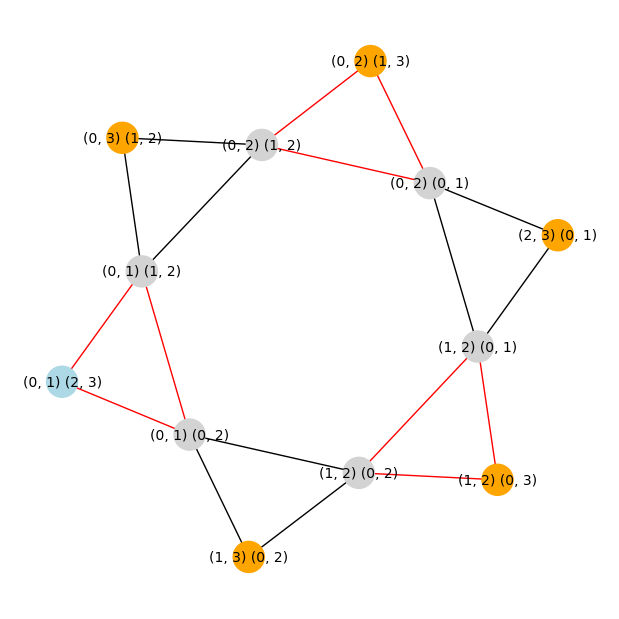

In [7]:
nodes = []
node_colors = []
for comb1 in list(combinations(range(4), 2)):
    for comb2 in list(combinations(range(4), 2)):
        all_columns = set(comb1) | set(comb2)
        if 0 in all_columns and 1 in all_columns and 2 in all_columns:
            nodes.append((comb1,comb2))
            if comb1==(0,1) and comb2==(2,3):
                node_colors.append("lightblue") # has all columns, but invalid as s1=0 and s2=0
            elif 3 in all_columns:
                node_colors.append("orange") # solution!
            else:
                node_colors.append("lightgray")
            
edges = []
edge_colors = []
for nodeA_index in range(len(nodes)):
    for nodeB_index in range(nodeA_index+1, len(nodes)):
        nodeA = nodes[nodeA_index]
        nodeB = nodes[nodeB_index]
        differences1 = len(set(nodeA[0]) ^ set(nodeB[0])) # difference in first table (IU1)
        differences2 = len(set(nodeA[1]) ^ set(nodeB[1])) # difference in second table (U2I)
        if (differences1==2 and differences2==0): # first set has changed
            edges.append((nodeA_index,nodeB_index))
            edge_colors.append("black")
        elif (differences1==0 and differences2==2): # second set has changed
            edges.append((nodeA_index,nodeB_index))
            edge_colors.append("red")

G = nx.Graph()
for i, node in enumerate(nodes):
    G.add_node(i, label=str(node[0])+" "+str(node[1]))

G.add_edges_from(edges)
pos = nx.spring_layout(G)  # You can use other layouts like circular_layout
labels = nx.get_node_attributes(G, 'label')  # Fetch the node labels

plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=False, node_size=500, node_color=node_colors, edge_color=edge_colors)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
plt.show()

If the above isn't a star, re-run! 

As you can see, making a step one at a time must lead to a solution at some point. 

If the end result is to get back to the initial node that basically just indicates that all options are equivalent. E.g., paper-scissors-rock,

In [8]:
U1 = np.array([[0,-1,1],[1,0,-1],[-1,1,0]])
U2 = np.array([[0,1,-1],[-1,0,1],[1,-1,0]])
solution1,solution2 = lemke_howson(U1,U2)
print("solution found",solution1.round(2),"and",solution2.round(2))

solution found [0.33 0.33 0.33] and [0.33 0.33 0.33]


The last thing to worry about is whether you can get into a loop that just stays in the 1-off area. But I am getting tired of this... It seems like that never happens. I guess the problem would be if you had columns 1,2, and 3 that keep swapping between themselves. But I think this is impossible for some reason...